In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


## Import Statement

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets , transforms
from torch.optim import lr_scheduler

from tqdm import tqdm

import random
import PIL 
from PIL import Image

from torch.autograd import Variable
from collections import OrderedDict
import math
from pathlib import Path
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch version {torch.__version__}\nPIL version {PIL.__version__}\nDevice {device}")


torch version 1.0.1.post2
PIL version 4.1.1
Device cuda


## Objective
1. Get more than 93% accuracy
2. Less then 1 million parameter
3. Max 250 Epoch
4. Use Data Augmentation

## Dataset

### Mean and Std calculation for Normalization

In [0]:
dataset = datasets.CIFAR10(train=True,root="data/" , download=True)
mean = np.mean(dataset.data ,axis=(0,1,2))
std = np.std(dataset.data ,axis=(0,1,2))
print(f"\nMean is {mean}\nStd dev is  {std}")

0it [00:00, ?it/s]

100%|█████████▉| 170467328/170498071 [02:41<00:00, 692909.79it/s]


Mean is [125.30691805 122.95039414 113.86538318]
Std dev is  [62.99321928 62.08870764 66.70489964]


### Transformation and Dataset Defination

In [0]:
train_transforms = transforms.Compose([transforms.RandomCrop(size=32 , padding=4 , padding_mode="symmetric",pad_if_needed=True),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor(),
                                       #transforms.Normalize(mean = mean , std=std)
                                      ])

val_transforms = transforms.Compose([transforms.ToTensor() , 
                                     #transforms.Normalize(mean=mean , std=std)
                                    ])

mean = torch.from_numpy(mean).type(torch.float32)
std = torch.from_numpy(std).type(torch.float32)

def denormalize(image):
  image = image.clone().detach().to("cpu") # take out of computational graph
  image = image.squeeze() 
  image = image.permute(1,2,0) # channel swapping H*W*C
 # image.mul_(std).add_(mean) # denormalize

  return image.numpy() 

trainset = datasets.CIFAR10(train=True,root="data/" , download=True,transform=train_transforms)
valset  = datasets.CIFAR10(train=False,root="data/" , download=True,transform=val_transforms)

Files already downloaded and verified
Files already downloaded and verified


### Augmentation Visualization
side by side comparison of original Image and augmented Image

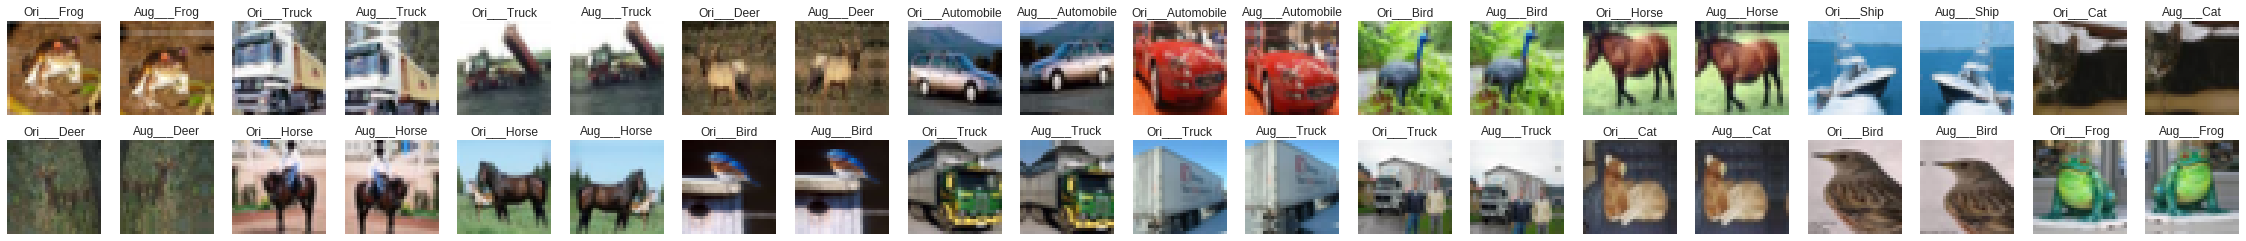

In [0]:
def show_img(ax,img,text):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.grid(False)
  ax.imshow(img)
  ax.set_title(text.title())

def visualizeAugmentation(augSet , normalset , no_of_images=8):
  """
    Visualizing Augmentation with normal set
    :augset : Augmented dataset
    :normalset :Normal dataset with no Augmentation
  """
  fig = plt.figure(figsize=(no_of_images*2,4))
  
  l = [x for x in range(1,2*no_of_images+1)] #indexing purpose 
  
  for i in range(no_of_images):
    
    ax  = fig.add_subplot(2,no_of_images,l[::2][i]) #odd numbers 
    ax2 = fig.add_subplot(2,no_of_images,l[1::2][i]) #even numbers
    
    show_img(ax , normalset[i][0],f"ori___{normalset.classes[normalset[i][1]]}")
    show_img(ax2 , denormalize(augSet[i][0]) , f"aug___{augSet.classes[augSet[i][1]]}")
  
visualizeAugmentation(trainset , dataset,no_of_images=20)

## Utility Func

###  No grad


In [0]:
from functools import wraps

def no_grad(func):
  @wraps(func)
  def wrapper(*args,**kwargs):
    with torch.no_grad():
      return func(*args,**kwargs)
  return wrapper

### Save Checkpoint

In [0]:
def save_checkpoint(epoch, epochs_since_improvement, model, optimizer,loss, best_loss, is_best,filepath=None):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement
    :param model: model
    :param optimizer: optimizer
    :param loss: validation loss in this epoch
    :param best_loss: best validation loss achieved so far (not necessarily in this checkpoint)
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'loss': loss,
             'best_loss': best_loss,
             'model': model.state_dict(),
             'optimizer': optimizer.state_dict()}
    filename = Path("/gdrive/My Drive/DenseNet/checkpoint.pt") if filepath is None else filepath
    is_best = is_best if filepath is None else False
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state,   Path("/gdrive/My Drive/DenseNet/BEST_checkpoint.pt"))

## Model Definition

### Calculate Summary

In [0]:
@no_grad
def summary(model, input_size, batch_size=-1, device="cuda"):

    def register_hook(module):

        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = "%s-%i" % (class_name, module_idx + 1)
            summary[m_key] = OrderedDict()
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["input_shape"][0] = batch_size
            if isinstance(output, (list, tuple)):
                summary[m_key]["output_shape"] = [
                    [-1] + list(o.size())[1:] for o in output
                ]
            else:
                summary[m_key]["output_shape"] = list(output.size())
                summary[m_key]["output_shape"][0] = batch_size

            params = 0
            if hasattr(module, "weight") and hasattr(module.weight, "size"):
                params += torch.prod(torch.LongTensor(list(module.weight.size())))
                summary[m_key]["trainable"] = module.weight.requires_grad
            if hasattr(module, "bias") and hasattr(module.bias, "size"):
                params += torch.prod(torch.LongTensor(list(module.bias.size())))
            summary[m_key]["nb_params"] = params

        if (
            not isinstance(module, nn.Sequential)
            and not isinstance(module, nn.ModuleList)
            and not (module == model)
        ):
            hooks.append(module.register_forward_hook(hook))

    device = device.lower()
    assert device in [
        "cuda",
        "cpu",
    ], "Input device is not valid, please specify 'cuda' or 'cpu'"

    if device == "cuda" and torch.cuda.is_available():
        dtype = torch.cuda.FloatTensor
    else:
        dtype = torch.FloatTensor

    # multiple inputs to the network
    if isinstance(input_size, tuple):
        input_size = [input_size]

    # batch_size of 2 for batchnorm
    x = [torch.rand(2, *in_size).type(dtype) for in_size in input_size]
    # print(type(x[0]))

    # create properties
    summary = OrderedDict()
    hooks = []
    model = model.to(device)
    # register hook
    model.apply(register_hook)

    # make a forward pass
    # print(x.shape)
    model(*x)

    # remove these hooks
    for h in hooks:
        h.remove()

    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer (type)", "Output Shape", "Param #")
    print(line_new)
    print("================================================================")
    total_params = 0
    total_output = 0
    trainable_params = 0
    for layer in summary:
        # input_shape, output_shape, trainable, nb_params
        line_new = "{:>20}  {:>25} {:>15}".format(
            layer,
            str(summary[layer]["output_shape"]),
            "{0:,}".format(summary[layer]["nb_params"]),
        )
        total_params += summary[layer]["nb_params"]
        total_output += np.prod(summary[layer]["output_shape"])
        if "trainable" in summary[layer]:
            if summary[layer]["trainable"] == True:
                trainable_params += summary[layer]["nb_params"]
        print(line_new)

    # assume 4 bytes/number (float on cuda).
    total_input_size = abs(np.prod(input_size) * batch_size * 4. / (1024 ** 2.))
    total_output_size = abs(2. * total_output * 4. / (1024 ** 2.))  # x2 for gradients
    total_params_size = abs(total_params.numpy() * 4. / (1024 ** 2.))
    total_size = total_params_size + total_output_size + total_input_size
    
    del model
    
    print("================================================================")
    print("Total params: {0:,}".format(total_params))
    print("Trainable params: {0:,}".format(trainable_params))
    print("Non-trainable params: {0:,}".format(total_params - trainable_params))
    print("----------------------------------------------------------------")
    print("Input size (MB): %0.2f" % total_input_size)
    print("Forward/backward pass size (MB): %0.2f" % total_output_size)
    print("Params size (MB): %0.2f" % total_params_size)
    print("Estimated Total Size (MB): %0.2f" % total_size)
    print("----------------------------------------------------------------")
    return total_params

### DenseNet-121 BC

In [0]:

class BottleNeck(nn.Module):
  def __init__(self,num_channels,growth_rate,bn_size,drop_rate):
    super(BottleNeck ,self).__init__()
    mid_channel = int(bn_size*growth_rate)
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.conv1 = nn.Conv2d(num_channels,mid_channel ,kernel_size=1 , bias=False)
    self.bn2 = nn.BatchNorm2d(mid_channel)
    self.conv2 = nn.Conv2d(mid_channel ,growth_rate , kernel_size=3 , bias=False,padding=1)
    self.drop_rate=drop_rate
    
  def forward(self,x):
    new_features = self.conv1(F.leaky_relu(self.bn1(x)))
    new_features = self.conv2(F.leaky_relu(self.bn2(new_features)))
    if self.drop_rate > 0:
      new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
    return torch.cat([x,new_features],1)

In [0]:



# Bottle Neck test
BottleNeck(24,12,4,0.3)

BottleNeck(
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

In [0]:
class Transition(nn.Module):
    def __init__(self, num_channels, num_out_channels):
        super(Transition, self).__init__()
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.conv1 = nn.Conv2d(num_channels, num_out_channels, kernel_size=1,
                               bias=False)

    def forward(self, x):
        out = self.conv1(F.leaky_relu(self.bn1(x)))
        out = F.avg_pool2d(out, 2)
        return out

In [0]:
class DenseNet(nn.Module):
  
  def __init__(self, growth_rate, depth, reduction , num_classes,bn_size=4,drop_rate=0.15):
    super(DenseNet , self).__init__()
    
    no_of_dense_blocks = (depth-4)//6 #16
    num_channels = 2*growth_rate #24
    
    self.conv1 = nn.Conv2d(3,num_channels , kernel_size=3 ,padding=1,bias=False) #first conv layer
    
    self.dense_block1 = self._gen_dense_block(num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate) # first dense block
    num_channels += no_of_dense_blocks * growth_rate
    num_out_channels = int(math.floor(num_channels*reduction))
    self.trans_block1 = Transition(num_channels , num_out_channels) #first transition block
    
    num_channels = num_out_channels
    self.dense_block2 = self._gen_dense_block(num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate) # second dense block
    num_channels += no_of_dense_blocks * growth_rate
    num_out_channels = int(math.floor(num_channels*reduction))
    self.trans_block2 = Transition(num_channels , num_out_channels) #first transition block
    
    num_channels = num_out_channels
    self.dense_block3 = self._gen_dense_block(num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate) #third Dense block
    num_channels += no_of_dense_blocks * growth_rate
    
    self.bn1 = nn.BatchNorm2d(num_channels) # final batch norm
    self.pool = nn.AvgPool2d(kernel_size=8, stride=1, padding=0)

    ## classifier
    self.classifier = self.create_head(num_channels , num_classes)

    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.constant_(m.bias, 0)
                
  def _gen_dense_block(self,num_channels , growth_rate, no_of_dense_blocks,bn_size,drop_rate):
    return nn.Sequential(*[ BottleNeck(int(num_channels+i*growth_rate) , growth_rate,bn_size,drop_rate) for i in range(no_of_dense_blocks)]) 
  
  def create_head(self,num_features , number_classes ,dropout_prob=0.15 ,activation_func =nn.LeakyReLU):
    features_lst = [num_features , num_features//2 , num_features//4]
    layers = []
    for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
      layers.append(nn.Linear(in_f , out_f))
      layers.append(activation_func())
      layers.append(nn.BatchNorm1d(out_f))
      if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
    layers.append(nn.Linear(features_lst[-1] , number_classes))
    return nn.Sequential(*layers)

  def forward(self,x):
    x = self.conv1(x)
    x = self.trans_block1(self.dense_block1(x))
    x = self.trans_block2(self.dense_block2(x))
    x = self.pool(F.leaky_relu(self.bn1(self.dense_block3(x))))
    x = x.view(x.size(0) , -1)
    x = self.classifier(x)
    return x

In [0]:
totalparams = summary(DenseNet(growth_rate=12, depth=100, reduction=0.6 , num_classes=len(trainset.classes)),(3,32,32));totalparams

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 32, 32]             648
       BatchNorm2d-2           [-1, 24, 32, 32]              48
            Conv2d-3           [-1, 48, 32, 32]           1,152
       BatchNorm2d-4           [-1, 48, 32, 32]              96
            Conv2d-5           [-1, 12, 32, 32]           5,184
        BottleNeck-6           [-1, 36, 32, 32]               0
       BatchNorm2d-7           [-1, 36, 32, 32]              72
            Conv2d-8           [-1, 48, 32, 32]           1,728
       BatchNorm2d-9           [-1, 48, 32, 32]              96
           Conv2d-10           [-1, 12, 32, 32]           5,184
       BottleNeck-11           [-1, 48, 32, 32]               0
      BatchNorm2d-12           [-1, 48, 32, 32]              96
           Conv2d-13           [-1, 48, 32, 32]           2,304
      BatchNorm2d-14           [-1, 48,

tensor(931420)

##  Parameters

In [0]:
batch_size=32
checkpoint = Path("/gdrive/My Drive/DenseNet/BEST_checkpoint.pt")
start_epoch = 0  # start at this epoch
epochs = 50  # number of epochs to run without early-stopping
epochs_since_improvement = 0  # number of epochs since there was an improvement in the validation metric
best_loss = 100.  # assume a high loss at first
workers = 4  # number of workers for loading data in the DataLoader
lr = 0.01  # learning rate
weight_decay = 1e-4  # weight decay
n_classes = len(trainset.classes)

## DataLoader

In [0]:
loader_param = { "batch_size":batch_size,
                 "pin_memory":True,
                 "num_workers":workers,
                "shuffle":True}

trainLoader = DataLoader(trainset,**loader_param)

valLoader = DataLoader(valset  ,**loader_param)


## Averge Meter

In [0]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Train method

In [0]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: CrossEntropy loss
    :param optimizer :optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    losses = AverageMeter()  # loss
    accuracy = AverageMeter() # Accuracy meter

    # Batches
    for images, labels in train_loader:
      
        optimizer.zero_grad()
        # Move to default device
        images = images.to(device) 
        labels = labels.to(device)

        # Forward prop.
        output = model(images)  
        preds = torch.argmax(output,1)
        # Loss
        loss = criterion(output, labels)  # scalar

        
        loss.backward()
        
        
        optimizer.step()

        losses.update(loss.item(), images.shape[0])
        accuracy.update(torch.sum(preds == labels.data).item())
        
        # Print status
    print(f"TRAIN  Loss {losses.avg}\t Accuracy {accuracy.sum/len(train_loader.dataset)}")
    return losses.avg

## Validation method

In [0]:
@no_grad
def validate(val_loader, model, criterion):
    """
    One epoch's validation.

    :param val_loader: DataLoader for training data
    :param model: model
    :param criterion: CrossEntropy loss
    """
    model.eval()  # inference mode enables dropout

    losses = AverageMeter()  # loss
    accuracy = AverageMeter() # Accuracy meter

    # Batches
    for images, labels in val_loader:

        # Move to default device
        images = images.to(device) 
        labels = labels.to(device)

        # Forward prop.
        output = model(images) 
        preds = torch.argmax(output,1)
        # Loss
        loss = criterion(output, labels)  # scalar

        losses.update(loss.item(), images.shape[0])
        accuracy.update(torch.sum(preds == labels.data).item())
        

        # Print status
    print(f"VAL  Loss {losses.avg}\t Accuracy {accuracy.sum/len(val_loader.dataset)}")
    return losses.avg

## Training

In [0]:
from tqdm import trange
def main(epochs):
  """
  
  Training and validation.
  """
  global epochs_since_improvement, start_epoch, best_loss, checkpoint
  model = DenseNet(growth_rate=12, depth=100, reduction=0.6 , num_classes=n_classes)
  model = model.to(device)

  # specify loss function (categorical cross-entropy)
  criterion = nn.CrossEntropyLoss()

  # specify optimizer
  optimizer = optim.SGD(model.parameters(), lr=lr,weight_decay=weight_decay,momentum=0.9,nesterov=True,dampening=0)
  scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=4,min_lr=1e-5,verbose=True)
  
  # Initialize model or load checkpoint
  if checkpoint.exists():
    checkpoint_dict = torch.load(checkpoint)
    start_epoch = checkpoint_dict['epoch'] + 1
    epochs_since_improvement = checkpoint_dict['epochs_since_improvement']
    best_loss = checkpoint_dict['best_loss']
    print('\nLoaded checkpoint from epoch %d. Best loss so far is %.3f.\n' % (start_epoch, best_loss))
    model.load_state_dict(checkpoint_dict['model'])
    optimizer.load_state_dict(checkpoint_dict['optimizer']) 

  # Epochs
  for epoch in trange(start_epoch,start_epoch+epochs):
      print("Current LR is " , optimizer.param_groups[0]['lr'])
      # One epoch's training
      train_loss = train(train_loader=trainLoader,
                         model=model,
                         criterion=criterion,
                         optimizer=optimizer,
                         epoch=epoch)

      # One epoch's validation
      val_loss = validate(val_loader=valLoader,
                          model=model,
                          criterion=criterion)
      scheduler.step(val_loss)
      # Did validation loss improve?
      is_best = val_loss < best_loss
      best_loss = min(val_loss, best_loss)

      if not is_best:
          epochs_since_improvement += 1
          print("\nEpochs since last improvement: %d\n" % (epochs_since_improvement,))

      else:
          epochs_since_improvement = 0

      # Save checkpoint
      save_checkpoint(epoch, epochs_since_improvement, model, optimizer, train_loss, best_loss, is_best)
  return model

In [0]:
model = main(epochs=epochs)


  0%|          | 0/50 [00:00<?, ?it/s]

Current LR is  0.01


170500096it [03:00, 837641.34it/s]                               

TRAIN  Loss 1.4814895293998718	 Accuracy 0.45446
VAL  Loss 1.3288366510391236	 Accuracy 0.527



  2%|▏         | 1/50 [06:05<4:58:24, 365.40s/it]

Current LR is  0.01
TRAIN  Loss 1.0549894808197022	 Accuracy 0.62494
VAL  Loss 0.9044517506599427	 Accuracy 0.6814



  4%|▍         | 2/50 [12:10<4:52:18, 365.38s/it]

Current LR is  0.01
TRAIN  Loss 0.8834607398605346	 Accuracy 0.68922
VAL  Loss 0.7541330414772034	 Accuracy 0.7345



  6%|▌         | 3/50 [18:16<4:46:12, 365.38s/it]

Current LR is  0.01
TRAIN  Loss 0.7612942564964295	 Accuracy 0.7346
VAL  Loss 0.6390506618976594	 Accuracy 0.7763



  8%|▊         | 4/50 [24:20<4:39:57, 365.16s/it]

Current LR is  0.01
TRAIN  Loss 0.6769971166706085	 Accuracy 0.76546
VAL  Loss 0.5755218473434448	 Accuracy 0.8032



 10%|█         | 5/50 [30:26<4:33:56, 365.25s/it]

Current LR is  0.01
TRAIN  Loss 0.615079960489273	 Accuracy 0.79086
VAL  Loss 0.5090750930309296	 Accuracy 0.8245



 12%|█▏        | 6/50 [36:31<4:27:57, 365.40s/it]

Current LR is  0.01
TRAIN  Loss 0.5613024745035171	 Accuracy 0.80828
VAL  Loss 0.5546239868879318	 Accuracy 0.8082

Epochs since last improvement: 1




 14%|█▍        | 7/50 [42:37<4:21:48, 365.32s/it]

Current LR is  0.01
TRAIN  Loss 0.5302954343700409	 Accuracy 0.81734
VAL  Loss 0.477622967338562	 Accuracy 0.8372



 16%|█▌        | 8/50 [48:42<4:15:47, 365.42s/it]

Current LR is  0.01
TRAIN  Loss 0.498036792345047	 Accuracy 0.82974
VAL  Loss 0.5389760755062103	 Accuracy 0.8166

Epochs since last improvement: 1




 18%|█▊        | 9/50 [54:47<4:09:39, 365.36s/it]

Current LR is  0.01
TRAIN  Loss 0.47187709329605104	 Accuracy 0.83914
VAL  Loss 0.4390202054977417	 Accuracy 0.8501



 20%|██        | 10/50 [1:00:53<4:03:37, 365.43s/it]

Current LR is  0.01
TRAIN  Loss 0.4516995756053925	 Accuracy 0.84466
VAL  Loss 0.5565335884094238	 Accuracy 0.8107

Epochs since last improvement: 1




 22%|██▏       | 11/50 [1:06:58<3:57:31, 365.41s/it]

Current LR is  0.01
TRAIN  Loss 0.43321028273582457	 Accuracy 0.85358
VAL  Loss 0.41325833265781403	 Accuracy 0.8573



 24%|██▍       | 12/50 [1:13:04<3:51:30, 365.53s/it]

Current LR is  0.01
TRAIN  Loss 0.4141558735227585	 Accuracy 0.85928
VAL  Loss 0.40378687686920167	 Accuracy 0.8608



 26%|██▌       | 13/50 [1:19:10<3:45:28, 365.64s/it]

Current LR is  0.01
TRAIN  Loss 0.40264438740730285	 Accuracy 0.86192
VAL  Loss 0.3780103269338608	 Accuracy 0.8696



 28%|██▊       | 14/50 [1:25:16<3:39:21, 365.61s/it]

Current LR is  0.01
TRAIN  Loss 0.3849474116373062	 Accuracy 0.86962
VAL  Loss 0.385879211640358	 Accuracy 0.8687

Epochs since last improvement: 1




 30%|███       | 15/50 [1:31:21<3:33:15, 365.59s/it]

Current LR is  0.01
TRAIN  Loss 0.3752863410615921	 Accuracy 0.87202
VAL  Loss 0.36310962529182433	 Accuracy 0.8781



 32%|███▏      | 16/50 [1:37:27<3:27:10, 365.60s/it]

Current LR is  0.01
TRAIN  Loss 0.36001025017261507	 Accuracy 0.8781
VAL  Loss 0.38254150421619415	 Accuracy 0.8703

Epochs since last improvement: 1




 34%|███▍      | 17/50 [1:43:32<3:20:57, 365.38s/it]

Current LR is  0.01
TRAIN  Loss 0.3490260129261017	 Accuracy 0.88132
VAL  Loss 0.3630263813734055	 Accuracy 0.8794



 36%|███▌      | 18/50 [1:49:36<3:14:42, 365.08s/it]

Current LR is  0.01
TRAIN  Loss 0.3403261285543442	 Accuracy 0.88352
VAL  Loss 0.3569094528913498	 Accuracy 0.8801



 38%|███▊      | 19/50 [1:55:41<3:08:33, 364.94s/it]

Current LR is  0.01
TRAIN  Loss 0.3295834201192856	 Accuracy 0.88836
VAL  Loss 0.3395621663093567	 Accuracy 0.8881



 40%|████      | 20/50 [2:01:46<3:02:31, 365.06s/it]

Current LR is  0.01
TRAIN  Loss 0.32278737534999846	 Accuracy 0.89016
VAL  Loss 0.36254207494258883	 Accuracy 0.8751

Epochs since last improvement: 1




 42%|████▏     | 21/50 [2:07:51<2:56:28, 365.12s/it]

Current LR is  0.01
TRAIN  Loss 0.3133104618358612	 Accuracy 0.89438
VAL  Loss 0.3379834243297577	 Accuracy 0.89



 44%|████▍     | 22/50 [2:13:57<2:50:29, 365.34s/it]

Current LR is  0.01
TRAIN  Loss 0.311785293841362	 Accuracy 0.89226
VAL  Loss 0.3090751298427582	 Accuracy 0.8971



 46%|████▌     | 23/50 [2:20:03<2:44:27, 365.45s/it]

Current LR is  0.01
TRAIN  Loss 0.3044917695426941	 Accuracy 0.89464
VAL  Loss 0.33605485107898714	 Accuracy 0.8861

Epochs since last improvement: 1




 48%|████▊     | 24/50 [2:26:08<2:38:22, 365.47s/it]

Current LR is  0.01
TRAIN  Loss 0.29612658767700195	 Accuracy 0.89878
VAL  Loss 0.3529298348903656	 Accuracy 0.8855

Epochs since last improvement: 2




 50%|█████     | 25/50 [2:32:14<2:32:16, 365.46s/it]

Current LR is  0.01
TRAIN  Loss 0.2878457746696472	 Accuracy 0.90102
VAL  Loss 0.36503951060771944	 Accuracy 0.8782

Epochs since last improvement: 3




 52%|█████▏    | 26/50 [2:38:19<2:26:08, 365.34s/it]

Current LR is  0.01
TRAIN  Loss 0.28062846271038056	 Accuracy 0.90368
VAL  Loss 0.28462540771961214	 Accuracy 0.9041



 54%|█████▍    | 27/50 [2:44:25<2:20:06, 365.50s/it]

Current LR is  0.01
TRAIN  Loss 0.27507888873100284	 Accuracy 0.90644
VAL  Loss 0.3146776859283447	 Accuracy 0.8979

Epochs since last improvement: 1




 56%|█████▌    | 28/50 [2:50:30<2:14:00, 365.50s/it]

Current LR is  0.01
TRAIN  Loss 0.2729045974779129	 Accuracy 0.9058
VAL  Loss 0.29925764067173005	 Accuracy 0.9023

Epochs since last improvement: 2




 58%|█████▊    | 29/50 [2:56:36<2:07:54, 365.47s/it]

Current LR is  0.01
TRAIN  Loss 0.2631226969051361	 Accuracy 0.90928
VAL  Loss 0.31250760419368745	 Accuracy 0.8937

Epochs since last improvement: 3




 60%|██████    | 30/50 [3:02:41<2:01:46, 365.31s/it]

Current LR is  0.01
TRAIN  Loss 0.2549266064453125	 Accuracy 0.91216
VAL  Loss 0.3257988083600998	 Accuracy 0.8955

Epochs since last improvement: 4




 62%|██████▏   | 31/50 [3:08:46<1:55:41, 365.33s/it]

Current LR is  0.01
TRAIN  Loss 0.2612184564304352	 Accuracy 0.91074
VAL  Loss 0.3006699100971222	 Accuracy 0.8993
Epoch    31: reducing learning rate of group 0 to 1.0000e-03.

Epochs since last improvement: 5




 64%|██████▍   | 32/50 [3:14:52<1:49:37, 365.39s/it]

Current LR is  0.001
TRAIN  Loss 0.1821836440372467	 Accuracy 0.93924
VAL  Loss 0.23536894280910492	 Accuracy 0.9201



 66%|██████▌   | 33/50 [3:20:57<1:43:32, 365.46s/it]

Current LR is  0.001
TRAIN  Loss 0.16456434574365617	 Accuracy 0.94488
VAL  Loss 0.23777775766849518	 Accuracy 0.9201

Epochs since last improvement: 1




 68%|██████▊   | 34/50 [3:27:02<1:37:23, 365.20s/it]

Current LR is  0.001
TRAIN  Loss 0.1522215092754364	 Accuracy 0.94894
VAL  Loss 0.23728807649612427	 Accuracy 0.9219

Epochs since last improvement: 2




 70%|███████   | 35/50 [3:33:06<1:31:14, 364.96s/it]

Current LR is  0.001
TRAIN  Loss 0.1471308104467392	 Accuracy 0.95038
VAL  Loss 0.2347320232629776	 Accuracy 0.9227



 72%|███████▏  | 36/50 [3:39:12<1:25:12, 365.17s/it]

Current LR is  0.001
TRAIN  Loss 0.1423280283641815	 Accuracy 0.95162
VAL  Loss 0.2366197547197342	 Accuracy 0.923

Epochs since last improvement: 1




 74%|███████▍  | 37/50 [3:45:17<1:19:05, 365.04s/it]

Current LR is  0.001
TRAIN  Loss 0.13765243270397187	 Accuracy 0.95226
VAL  Loss 0.23777011692523956	 Accuracy 0.9243

Epochs since last improvement: 2




 76%|███████▌  | 38/50 [3:51:21<1:12:58, 364.89s/it]

Current LR is  0.001
TRAIN  Loss 0.12898464656114578	 Accuracy 0.95642
VAL  Loss 0.23568562071323396	 Accuracy 0.9258

Epochs since last improvement: 3




 78%|███████▊  | 39/50 [3:57:26<1:06:52, 364.79s/it]

Current LR is  0.001
TRAIN  Loss 0.13218916611194612	 Accuracy 0.9541
VAL  Loss 0.23160878009796143	 Accuracy 0.9269



 80%|████████  | 40/50 [4:03:30<1:00:47, 364.75s/it]

Current LR is  0.001
TRAIN  Loss 0.12818688903808595	 Accuracy 0.9561
VAL  Loss 0.23795713610649108	 Accuracy 0.9253

Epochs since last improvement: 1




 82%|████████▏ | 41/50 [4:09:34<54:41, 364.58s/it]  

Current LR is  0.001
TRAIN  Loss 0.1257792422580719	 Accuracy 0.95588
VAL  Loss 0.24294707012176514	 Accuracy 0.9237

Epochs since last improvement: 2




 84%|████████▍ | 42/50 [4:15:39<48:36, 364.52s/it]

Current LR is  0.001
TRAIN  Loss 0.12295655189037323	 Accuracy 0.95872
VAL  Loss 0.24093882796764374	 Accuracy 0.9237

Epochs since last improvement: 3




 86%|████████▌ | 43/50 [4:21:43<42:30, 364.36s/it]

Current LR is  0.001
TRAIN  Loss 0.11859927082061768	 Accuracy 0.95908
VAL  Loss 0.2365607542514801	 Accuracy 0.9274

Epochs since last improvement: 4




 88%|████████▊ | 44/50 [4:27:47<36:25, 364.32s/it]

Current LR is  0.001
TRAIN  Loss 0.11999890264511108	 Accuracy 0.95852
VAL  Loss 0.24487603776454925	 Accuracy 0.9252
Epoch    44: reducing learning rate of group 0 to 1.0000e-04.

Epochs since last improvement: 5




 90%|█████████ | 45/50 [4:33:51<30:21, 364.21s/it]

Current LR is  0.0001
TRAIN  Loss 0.10908328997135162	 Accuracy 0.96254
VAL  Loss 0.24103214616775512	 Accuracy 0.927

Epochs since last improvement: 6




 92%|█████████▏| 46/50 [4:39:55<24:16, 364.09s/it]

Current LR is  0.0001
TRAIN  Loss 0.10957612010002137	 Accuracy 0.96252
VAL  Loss 0.23976302518844606	 Accuracy 0.9269

Epochs since last improvement: 7




 94%|█████████▍| 47/50 [4:45:58<18:11, 363.95s/it]

Current LR is  0.0001
TRAIN  Loss 0.10702463733673095	 Accuracy 0.9638
VAL  Loss 0.24215915520191192	 Accuracy 0.9261

Epochs since last improvement: 8




 96%|█████████▌| 48/50 [4:52:02<12:07, 363.81s/it]

Current LR is  0.0001
TRAIN  Loss 0.10551263258457184	 Accuracy 0.96406
VAL  Loss 0.24165199716091157	 Accuracy 0.9266

Epochs since last improvement: 9




 98%|█████████▊| 49/50 [4:58:07<06:04, 364.26s/it]

Current LR is  0.0001
TRAIN  Loss 0.10766995559215546	 Accuracy 0.96372
VAL  Loss 0.24088586525917052	 Accuracy 0.9269
Epoch    49: reducing learning rate of group 0 to 1.0000e-05.

Epochs since last improvement: 10




100%|██████████| 50/50 [5:04:13<00:00, 364.58s/it]


## Per Class Accuracy

In [0]:
## load the model
@no_grad
def perClassAccuracy(model , classes):
  model = main(epochs=0)
  class_correct = np.zeros(len(classes) ,dtype =np.int64 )
  class_total = np.zeros_like(class_correct,dtype =np.int64 )
  model.eval()
  
  for data ,target in valLoader:
    data,target =data.to(device) , target.to(device)
    output =model(data)
    preds = torch.argmax(output,1)
    for prediction , label in zip(preds , target.data):
      if prediction == label:
        class_correct[prediction]+=1
      class_total[label]+=1
  per = np.round((100*class_correct/class_total) ,4)
  out = "\n".join([f"{name} :- {acc} %" for name ,acc in zip(classes , per)])
  return out+"\ntotal acc is {0}%".format(100* sum(class_correct)/sum(class_total))

print(perClassAccuracy(model , trainset.classes))


0it [00:00, ?it/s]



Loaded checkpoint from epoch 40. Best loss so far is 0.232.

airplane :- 94.3 %
automobile :- 97.4 %
bird :- 89.8 %
cat :- 86.7 %
deer :- 91.4 %
dog :- 88.0 %
frog :- 93.2 %
horse :- 93.7 %
ship :- 97.0 %
truck :- 95.4 %
total acc is 92.69%


## Intermediate Result :- 92.69 % Accuracy

## Visualizing the wrong prediction and where exactly model is confused

In [0]:
## load the model
model = main(epochs=0)
@no_grad
def allwrong_prediction(classes ,model):
  test_array =[]
  model.eval()
  for data ,target in valLoader:
    data,target =data.to(device) , target.to(device)
    output =model(data)
    preds = torch.argmax(output,1)
    for prediction , label in zip(preds , target.data):
      if prediction != label:
          test_array.append([data ,classes[prediction] ,classes[label]])
  return test_array

s = allwrong_prediction(trainset.classes , model)


0it [00:00, ?it/s]



Loaded checkpoint from epoch 40. Best loss so far is 0.232.



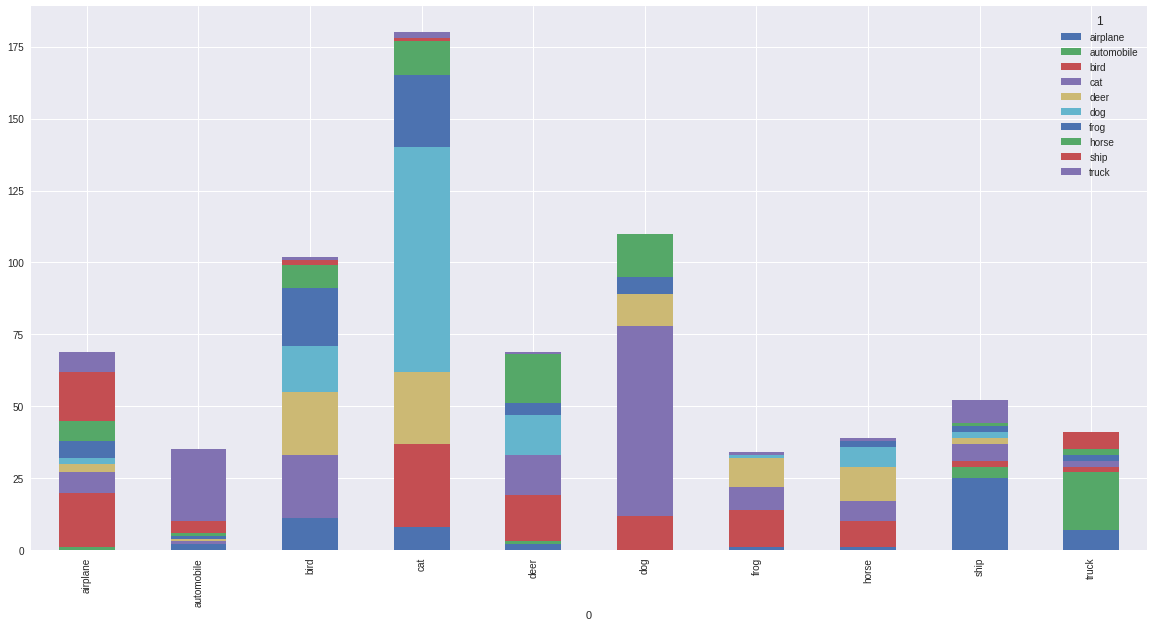

In [0]:
s_d = [(y,z) for x ,y,z in s]
df = pd.DataFrame(s_d)
gr = df.groupby([0,1])
gr.apply(len).unstack().plot(kind='bar', stacked=True, figsize=(20,10))

## Inferencing Graph
 Model is confused between airplane,ship,bird

## plot confusion matrix


In [0]:
from sklearn.metrics import classification_report, confusion_matrix
model = main(0)
pred = []
la=[]
with torch.no_grad():
  for image , label in valLoader:
    image , label = image.to(device) , label.to(device)
    output = model(image)
    output = F.softmax(output,dim=1)
    preds = torch.argmax(output,dim=1)
    pred.extend(preds.clone().detach().cpu().tolist())
    la.extend(label.clone().detach().cpu().tolist())






0it [00:00, ?it/s]






Loaded checkpoint from epoch 47. Best loss so far is 0.227.



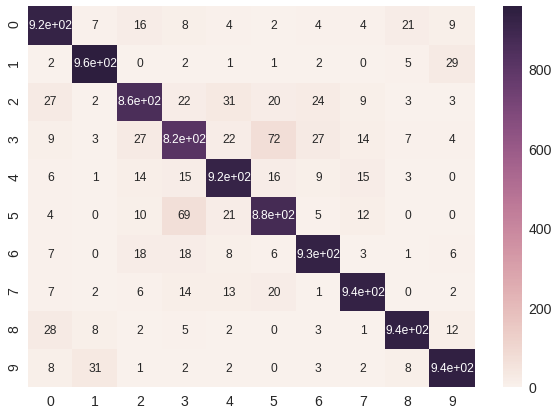

In [0]:
cm = confusion_matrix(la,
                      pred)
 
# Visualizing of confusion matrix
import seaborn as sn
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size

## The END